#Project Delta Airlines - Predictive Attrition
Code by Cynthia Widjaja
for Team 13

##Install and load necessary libraries

In [84]:
!pip install pandas scikit-learn

In [85]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

##Load the dataset

In [86]:
# Load the dataset
file_path = '/content/drive/MyDrive/0 Delta Clicked /Delta Airlines Cleansed Data.xlsx'
df1 = pd.read_excel(file_path, sheet_name='Frequent Flier Cleansed')
df2 = pd.read_excel(file_path, sheet_name='Flier Upcoming Flights')

# Check the first few rows to understand the structure
print("Sheet 1:\n", df1.head())
print("Sheet 1:\n", df2.head())


# Get the number of rows and columns in the DataFrame
num_rows, num_columns = df1.shape

# Print the results
print(f'Number of data entries (rows) in the Sheet 1: {num_rows}')
print(f'Number of columns in the Sheet 1: {num_columns}')

# Get the number of rows and columns in the DataFrame
num_rows2, num_columns2 = df2.shape

# Print the results
print(f'Number of data entries (rows) in the Sheet 2: {num_rows2}')
print(f'Number of columns in the Sheet 2: {num_columns2}')

Sheet 1:
   Record Creation Date  Join Date  Frequent Flier Number First Name Last Name  \
0           2024-02-27 1988-07-08           7.234618e+09     Debbie    Spears   
1           2021-03-07 1988-07-08           7.234618e+09     Debbie    Spears   
2           2023-01-31 1988-07-08           7.234618e+09     Debbie    Spears   
3           2021-08-21 2022-06-16           5.511217e+08       Kyle     Boone   
4           2022-03-01 2022-06-16           5.511217e+08       Kyle     Boone   

    Inquiry Type Most Recent Flight #  Lounge Used? Departing Airport  \
0  Flight Status            G35206241         False               DFW   
1     New Flight            V81311927          True               JFK   
2  Cancel Flight            H82295055         False               MIA   
3     New Flight            E39886834          True               SEA   
4     New Flight            R04390271          True               SFO   

  Arrival Airport  Planned Snack?  Additional Snack?  \
0       

##Handle missing values, if any

In [87]:
# Check for missing values for Sheet 1 - Frequent Flier Cleansed
print(df1.isnull().sum())

Record Creation Date          1000
Join Date                     1000
Frequent Flier Number         1000
First Name                    1000
Last Name                     1000
Inquiry Type                  1000
Most Recent Flight #          1000
Lounge Used?                     0
Departing Airport             1000
Arrival Airport               1000
Planned Snack?                1000
Additional Snack?             1000
# of Included Checked Bags    1000
Total # of Checked Bags       1000
Flight Delayed?                  0
dtype: int64


In [88]:
# Check for missing values for Sheet 2 - Flier Upcoming Flights
print(df2.isnull().sum())

Join Date                0
Frequent Flier Number    0
First Name               0
Last Name                0
Flight Number            0
Flight Date              0
Departing City           0
Arrival City             0
Departure Time           0
Departure Time Zone      0
Arrival Time             0
Arrival Time Zone        0
Cost                     0
Car Rental Addon $       0
Hotel Addon $            0
dtype: int64


## Drop rows with any missing values

In [89]:
# Drop rows with any missing values
df1 = df1.dropna()

# Display the number of rows after dropping
print(f'Number of rows after dropping incomplete data: {df1.shape[0]}')

# Optional: If you want to reset the index after dropping rows
df1.reset_index(drop=True, inplace=True)

# Optional: Show the cleaned DataFrame
print(df1.head())

Number of rows after dropping incomplete data: 9211
  Record Creation Date  Join Date  Frequent Flier Number First Name Last Name  \
0           2024-02-27 1988-07-08           7.234618e+09     Debbie    Spears   
1           2021-03-07 1988-07-08           7.234618e+09     Debbie    Spears   
2           2023-01-31 1988-07-08           7.234618e+09     Debbie    Spears   
3           2021-08-21 2022-06-16           5.511217e+08       Kyle     Boone   
4           2022-03-01 2022-06-16           5.511217e+08       Kyle     Boone   

    Inquiry Type Most Recent Flight #  Lounge Used? Departing Airport  \
0  Flight Status            G35206241         False               DFW   
1     New Flight            V81311927          True               JFK   
2  Cancel Flight            H82295055         False               MIA   
3     New Flight            E39886834          True               SEA   
4     New Flight            R04390271          True               SFO   

  Arrival Airport  Pla

In [90]:
# Recheck the data for Sheet 1
# Check for missing values for Sheet 1 - Frequent Flier Cleansed
print(df1.isnull().sum())

Record Creation Date          0
Join Date                     0
Frequent Flier Number         0
First Name                    0
Last Name                     0
Inquiry Type                  0
Most Recent Flight #          0
Lounge Used?                  0
Departing Airport             0
Arrival Airport               0
Planned Snack?                0
Additional Snack?             0
# of Included Checked Bags    0
Total # of Checked Bags       0
Flight Delayed?               0
dtype: int64


## Remove currency from the Cost, Car Rental Addon and Hotel Addon and add Cost in USD, Car Rental Addon in USD and Hotel Addon in USD, preserve the original currency in another column

In [91]:
# Manual currency exchange, date Oct 28, 2024, 10AM
# https://www.xe.com/currencyconverter/
# Current exchange rates to USD
exchange_rates = {
    'USD': 1.0,
    'MXN': 20.008,  # 1 USD = 20.008 MXN
    'AED': 3.67,    # 1 USD = 3.67 AED
    'AUD': 1.61,    # 1 USD = 1.61 AUD
    'JPY': 149.64,  # 1 USD = 149.64 JPY
    'CAD': 1.39,    # 1 USD = 1.39 CAD
    'BRL': 5.71,    # 1 USD = 5.71 BRL
    'GBP': 0.77,    # 1 USD = 0.77 GBP
    'EUR': 0.92,    # 1 USD = 0.92 EUR
    'HKD': 7.85     # 1 USD = 7.85 HKD
}

In [92]:


# Function to extract numeric value and convert to USD
def convert_to_usd(value, exchange_rates):
    currency_code = value[-3:]  # Assuming the last 3 characters are the currency code
    amount = float(value[:-4])  # Convert everything except the last 3 characters and a space to a float
    # Convert to USD using the provided exchange rate, default to 1 if currency not found
    amount_in_usd = amount * exchange_rates.get(currency_code, 1)
    return currency_code, amount_in_usd

# Apply the function to each relevant column in df2
for column in ["Cost", "Car Rental Addon $", "Hotel Addon $"]:
    df2[f"{column} Currency"], df2[f"{column} in USD"] = zip(*df2[column].apply(lambda x: convert_to_usd(x, exchange_rates)))

# Display the updated DataFrame
print(df2)

       Join Date  Frequent Flier Number First Name Last Name Flight Number  \
0     1988-07-08             7234617746     Debbie    Spears        DL1408   
1     1988-07-08             7234617746     Debbie    Spears        DL3882   
2     1988-07-08             7234617746     Debbie    Spears        DL4173   
3     1988-07-08             7234617746     Debbie    Spears        DL8231   
4     1988-07-08             7234617746     Debbie    Spears        DL9014   
...          ...                    ...        ...       ...           ...   
15073 2007-03-24               64007954      Katie  Martinez        DL3710   
15074 2007-03-24               64007954      Katie  Martinez        DL5103   
15075 2007-03-24               64007954      Katie  Martinez        DL2399   
15076 2007-03-24               64007954      Katie  Martinez        DL3168   
15077 2007-03-24               64007954      Katie  Martinez        DL6168   

      Flight Date   Departing City Arrival City Departure Time 

## Removing outliers from certain features

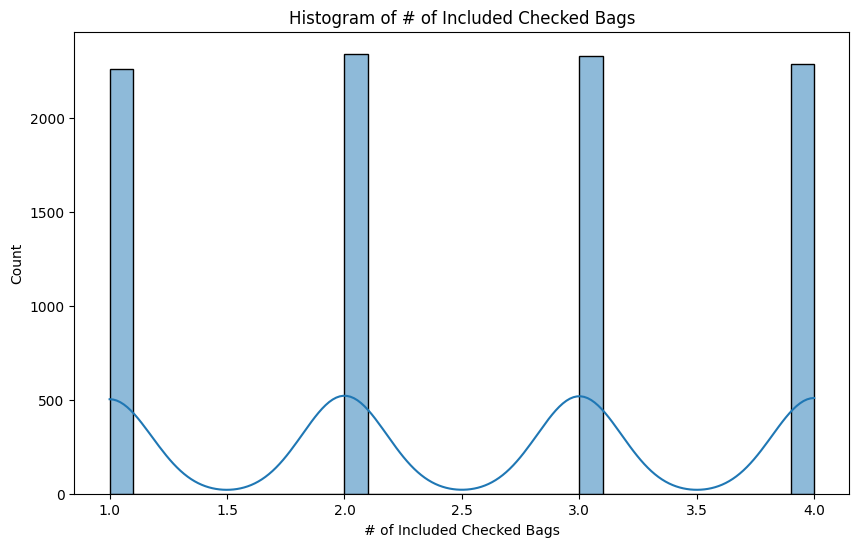

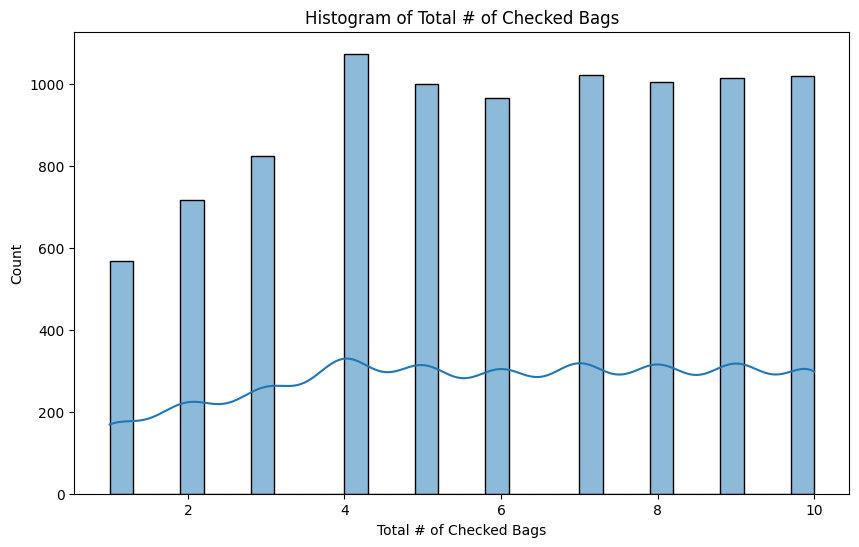

In [93]:
# Histogram for # of Included Checked Bags
plt.figure(figsize=(10, 6))
sns.histplot(df1['# of Included Checked Bags'], bins=30, kde=True)
plt.title('Histogram of # of Included Checked Bags')
plt.show()

# Histogram for Total # of Checked Bags
plt.figure(figsize=(10, 6))
sns.histplot(df1['Total # of Checked Bags'], bins=30, kde=True)
plt.title('Histogram of Total # of Checked Bags')
plt.show()

In [94]:
# Define a function to identify outliers based on IQR
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Check for outliers in the USD-converted columns
for column in ['Cost in USD', 'Car Rental Addon $ in USD', 'Hotel Addon $ in USD']:
    outliers = find_outliers_iqr(df2, column)
    print(f"Outliers in {column}:\n", outliers)

Outliers in Cost in USD:
        Join Date  Frequent Flier Number First Name Last Name Flight Number  \
4     1988-07-08             7234617746     Debbie    Spears        DL9014   
5     1988-07-08             7234617746     Debbie    Spears        DL7806   
8     2022-06-16              551121699       Kyle     Boone        DL8341   
30    1995-11-01             3414172587    Abigail      Dean        DL6783   
31    2009-02-23             5259235142    Richard     Munoz        DL3688   
...          ...                    ...        ...       ...           ...   
15063 2018-11-15             2557356607     Jeremy       Kim        DL1885   
15064 2018-11-15             2557356607     Jeremy       Kim        DL6957   
15068 2018-11-15             2557356607     Jeremy       Kim        DL5264   
15069 2018-11-15             2557356607     Jeremy       Kim        DL8406   
15077 2007-03-24               64007954      Katie  Martinez        DL6168   

      Flight Date  Departing City    

##Convert to Binary



In [95]:
# Convert boolean columns ('Lounge Used?', 'Planned Snack?', 'Additional Snack?', 'Flight Delayed?') to binary (0 and 1)
binary_columns = ['Lounge Used?', 'Planned Snack?', 'Additional Snack?', 'Flight Delayed?']
df1[binary_columns] = df1[binary_columns].astype(int)

# Display the DataFrame to confirm changes
print(df1.head())

  Record Creation Date  Join Date  Frequent Flier Number First Name Last Name  \
0           2024-02-27 1988-07-08           7.234618e+09     Debbie    Spears   
1           2021-03-07 1988-07-08           7.234618e+09     Debbie    Spears   
2           2023-01-31 1988-07-08           7.234618e+09     Debbie    Spears   
3           2021-08-21 2022-06-16           5.511217e+08       Kyle     Boone   
4           2022-03-01 2022-06-16           5.511217e+08       Kyle     Boone   

    Inquiry Type Most Recent Flight #  Lounge Used? Departing Airport  \
0  Flight Status            G35206241             0               DFW   
1     New Flight            V81311927             1               JFK   
2  Cancel Flight            H82295055             0               MIA   
3     New Flight            E39886834             1               SEA   
4     New Flight            R04390271             1               SFO   

  Arrival Airport  Planned Snack?  Additional Snack?  \
0             DEN 

# Feature Engineering

## Tenure (Join date - Oct 28, 2024)

In [96]:
import pandas as pd
from datetime import datetime

# Convert 'Join Date' to datetime format if it's not already
df2['Join Date'] = pd.to_datetime(df2['Join Date'])

# Calculate tenure as the difference in days, months, or years
today = datetime.today()
df2['Tenure (Years)'] = (today - df2['Join Date']).dt.days / 365

print(df2)

       Join Date  Frequent Flier Number First Name Last Name Flight Number  \
0     1988-07-08             7234617746     Debbie    Spears        DL1408   
1     1988-07-08             7234617746     Debbie    Spears        DL3882   
2     1988-07-08             7234617746     Debbie    Spears        DL4173   
3     1988-07-08             7234617746     Debbie    Spears        DL8231   
4     1988-07-08             7234617746     Debbie    Spears        DL9014   
...          ...                    ...        ...       ...           ...   
15073 2007-03-24               64007954      Katie  Martinez        DL3710   
15074 2007-03-24               64007954      Katie  Martinez        DL5103   
15075 2007-03-24               64007954      Katie  Martinez        DL2399   
15076 2007-03-24               64007954      Katie  Martinez        DL3168   
15077 2007-03-24               64007954      Katie  Martinez        DL6168   

      Flight Date   Departing City Arrival City Departure Time 

## Average Yearly Spend per frequent flyer for the last 2 years

In [97]:

# Convert relevant columns to numeric if necessary
df2['Cost in USD'] = df2['Cost in USD'].astype(float)
df2['Car Rental Addon $ in USD'] = df2['Car Rental Addon $ in USD'].astype(float)
df2['Hotel Addon $ in USD'] = df2['Hotel Addon $ in USD'].astype(float)

# Ensure 'Flight Date' is in datetime format
df2['Flight Date'] = pd.to_datetime(df2['Flight Date'])

# Filter data to include only records from 2024 and 2025
df2_filtered = df2[(df2['Flight Date'].dt.year == 2024) | (df2['Flight Date'].dt.year == 2025)]

# Calculate the total spend per flight within the 2024-2025 timeframe
df2_filtered['Total Spend in USD'] = (
    df2_filtered['Cost in USD'] +
    df2_filtered['Car Rental Addon $ in USD'] +
    df2_filtered['Hotel Addon $ in USD']
)

# Group by Frequent Flier Number to calculate total spend over the two years (2024-2025)
total_spend = df2_filtered.groupby('Frequent Flier Number')['Total Spend in USD'].sum().reset_index()
total_spend.columns = ['Frequent Flier Number', 'Total Spend in USD (2024-2025)']

# Calculate the average yearly spend over 2024-2025 (dividing total by 2 for two years)
total_spend['Average Yearly Spend in USD'] = total_spend['Total Spend in USD (2024-2025)'] / 2

# Calculate thresholds for tenure and average yearly spend
tenure_threshold = df2['Tenure (Years)'].mean()  # or df2['Tenure (Years)'].median()
yearly_spend_threshold = total_spend['Average Yearly Spend in USD'].mean()  # or use median

# Merge the average yearly spend data back to the original data to use thresholds
df2 = df2.merge(total_spend[['Frequent Flier Number', 'Average Yearly Spend in USD']], on='Frequent Flier Number', how='left')

# Display the result and thresholds
print(total_spend[['Frequent Flier Number', 'Average Yearly Spend in USD']])
print(f"Tenure Threshold: {tenure_threshold}")
print(f"Yearly Spend Threshold: {yearly_spend_threshold}")

      Frequent Flier Number  Average Yearly Spend in USD
0                   5445899                  75200.93520
1                   5911884                   7029.21710
2                   8157372                   8160.06770
3                  10806849                  18897.30201
4                  12109458                   7148.89905
...                     ...                          ...
1995             9985932564                  87305.96077
1996             9986826496                   9278.13865
1997             9989457726                  10132.84120
1998             9994295877                  99350.49465
1999             9998535377                  11397.10765

[2000 rows x 2 columns]
Tenure Threshold: 18.660344836984667
Yearly Spend Threshold: 59354.313453484996


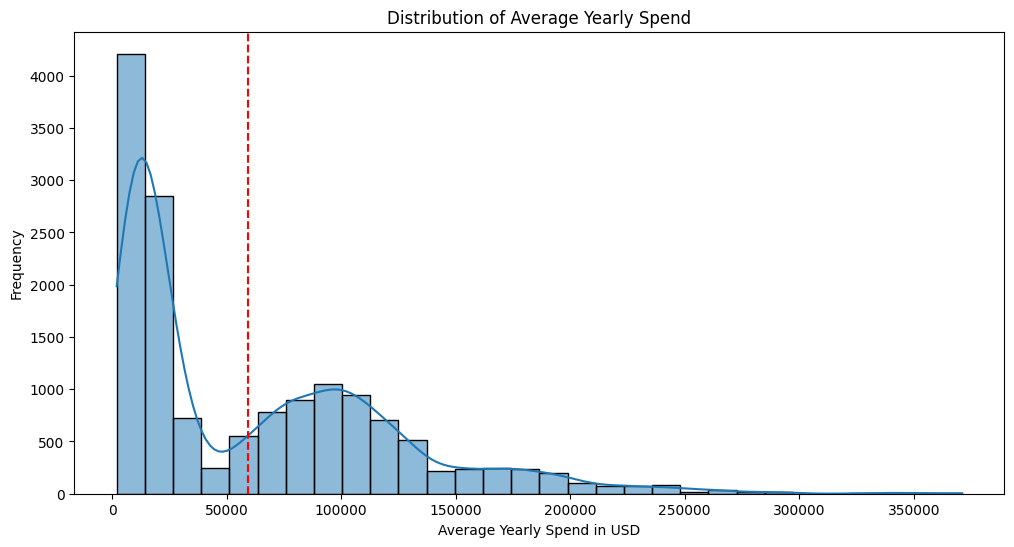

In [98]:
import seaborn as sns

# Distribution of Average Yearly Spend
plt.figure(figsize=(12, 6))
sns.histplot(df2['Average Yearly Spend in USD'], bins=30, kde=True)
plt.axvline(yearly_spend_threshold, color='r', linestyle='--')
plt.title('Distribution of Average Yearly Spend')
plt.xlabel('Average Yearly Spend in USD')
plt.ylabel('Frequency')
plt.show()

show data before merge

In [99]:
print("Header Sheet 1 for df1 \n")
# Print column names and their respective counts
for column in df1.columns:
    count = df1[column].count()  # Counts non-null entries in the column
    print(f"{column}: {count}")


print("Header Sheet 2 for df2 \n")
# Print column names and their respective counts
for column in df2.columns:
    count = df2[column].count()  # Counts non-null entries in the column
    print(f"{column}: {count}")

Header Sheet 1 for df1 

Record Creation Date: 9211
Join Date: 9211
Frequent Flier Number: 9211
First Name: 9211
Last Name: 9211
Inquiry Type: 9211
Most Recent Flight #: 9211
Lounge Used?: 9211
Departing Airport: 9211
Arrival Airport: 9211
Planned Snack?: 9211
Additional Snack?: 9211
# of Included Checked Bags: 9211
Total # of Checked Bags: 9211
Flight Delayed?: 9211
Header Sheet 2 for df2 

Join Date: 15078
Frequent Flier Number: 15078
First Name: 15078
Last Name: 15078
Flight Number: 15078
Flight Date: 15078
Departing City: 15078
Arrival City: 15078
Departure Time: 15078
Departure Time Zone: 15078
Arrival Time: 15078
Arrival Time Zone: 15078
Cost: 15078
Car Rental Addon $: 15078
Hotel Addon $: 15078
Cost Currency: 15078
Cost in USD: 15078
Car Rental Addon $ Currency: 15078
Car Rental Addon $ in USD: 15078
Hotel Addon $ Currency: 15078
Hotel Addon $ in USD: 15078
Tenure (Years): 15078
Average Yearly Spend in USD: 15078


## Merge the 2 dataframe

In [100]:
# Select necessary columns from df1
df1_relevant = df1[['Frequent Flier Number', 'Inquiry Type', 'Lounge Used?', 'Planned Snack?', 'Additional Snack?', 'Flight Delayed?']]

# Merge df1 and df2 on 'Frequent Flier Number'
merged_df = pd.merge(df1_relevant, df2, on='Frequent Flier Number', how='inner')

print("Header merged sheet for merged_df \n")

# Print column names and their respective counts
for column in merged_df.columns:
    count = merged_df[column].count()  # Counts non-null entries in the column
    print(f"{column}: {count}")

Header merged sheet for merged_df 

Frequent Flier Number: 69211
Inquiry Type: 69211
Lounge Used?: 69211
Planned Snack?: 69211
Additional Snack?: 69211
Flight Delayed?: 69211
Join Date: 69211
First Name: 69211
Last Name: 69211
Flight Number: 69211
Flight Date: 69211
Departing City: 69211
Arrival City: 69211
Departure Time: 69211
Departure Time Zone: 69211
Arrival Time: 69211
Arrival Time Zone: 69211
Cost: 69211
Car Rental Addon $: 69211
Hotel Addon $: 69211
Cost Currency: 69211
Cost in USD: 69211
Car Rental Addon $ Currency: 69211
Car Rental Addon $ in USD: 69211
Hotel Addon $ Currency: 69211
Hotel Addon $ in USD: 69211
Tenure (Years): 69211
Average Yearly Spend in USD: 69211


## One-hot encoding for the inquiry type

In [101]:
# One-hot encode the 'Inquiry Type' column
merged_df = pd.get_dummies(merged_df, columns=['Inquiry Type'], prefix='Inquiry')


# Print column names and their respective counts
for column in merged_df.columns:
    count = merged_df[column].count()  # Counts non-null entries in the column
    print(f"{column}: {count}")

Frequent Flier Number: 69211
Lounge Used?: 69211
Planned Snack?: 69211
Additional Snack?: 69211
Flight Delayed?: 69211
Join Date: 69211
First Name: 69211
Last Name: 69211
Flight Number: 69211
Flight Date: 69211
Departing City: 69211
Arrival City: 69211
Departure Time: 69211
Departure Time Zone: 69211
Arrival Time: 69211
Arrival Time Zone: 69211
Cost: 69211
Car Rental Addon $: 69211
Hotel Addon $: 69211
Cost Currency: 69211
Cost in USD: 69211
Car Rental Addon $ Currency: 69211
Car Rental Addon $ in USD: 69211
Hotel Addon $ Currency: 69211
Hotel Addon $ in USD: 69211
Tenure (Years): 69211
Average Yearly Spend in USD: 69211
Inquiry_Cancel Flight: 69211
Inquiry_Flight Deal: 69211
Inquiry_Flight Status: 69211
Inquiry_New Flight: 69211


#Linear Regression


Mean Squared Error: 0.11931311530484429
Mean Absolute Error: 0.2843934263283781
R-squared: 0.4867306037644137
Predicted Attrition Scores:
 [0.4285706  0.59128907 1.04334533 ... 0.94843814 0.76782185 0.37621122]


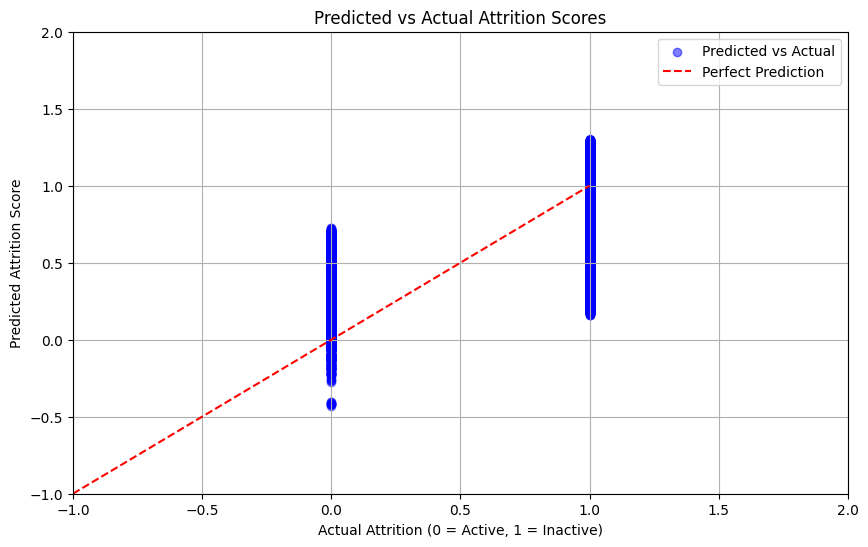

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Example: using quantiles
threshold_years = merged_df['Tenure (Years)'].quantile(0.75)  # Using 75th percentile
yearly_spend_threshold = merged_df['Average Yearly Spend in USD'].quantile(0.25) # Using 25th percentile

# Define a target column 'Attrition' (1 for inactive, 0 for active)
#df2['Attrition'] = (df2['Tenure (Years)'] > tenure_threshold) | (df2['Average Yearly Spend in USD'] < yearly_spend_threshold) | df2['Number of Flights'] > flight_threshold

merged_df['Attrition'] = ((merged_df['Tenure (Years)'] < tenure_threshold) |
                          (merged_df['Average Yearly Spend in USD'] < yearly_spend_threshold)
 #                        | (merged_df['Number of Flights'] > flight_threshold)
                         )


# Define features (X) and target (y)
X = merged_df[[ 'Lounge Used?', 'Planned Snack?', 'Additional Snack?', 'Flight Delayed?','Tenure (Years)', 'Average Yearly Spend in USD'
                  ,'Inquiry_Cancel Flight',
                  'Inquiry_Flight Deal',
                  'Inquiry_Flight Status',
                  'Inquiry_New Flight',
                #'Number of Flights'
                ]]
y = merged_df['Attrition'].astype(float)  # Cast to float for linear regression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Display predicted attrition scores (probabilities)
print("Predicted Attrition Scores:\n", y_pred)

# Scatter plot for Actual vs Predicted Attrition Scores
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')

# Line for perfect prediction
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--', label='Perfect Prediction')

# Set limits for axes
plt.ylim(-1, 2)  # Predicted values range from -1 to 1
plt.xlim(-1, 2)   # Actual values are 0 or 1

# Labels and title
plt.xlabel("Actual Attrition (0 = Active, 1 = Inactive)")
plt.ylabel("Predicted Attrition Score")
plt.title("Predicted vs Actual Attrition Scores")

# Display legend and plot
plt.legend()
plt.grid(True)
plt.show()

# Logistic Regression

Attrition
True     43563
False    25648
Name: count, dtype: int64
Accuracy: 0.8480820631366034
Confusion Matrix:
 [[4461  627]
 [1476 7279]]
Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5088
        True       0.92      0.83      0.87      8755

    accuracy                           0.85     13843
   macro avg       0.84      0.85      0.84     13843
weighted avg       0.86      0.85      0.85     13843



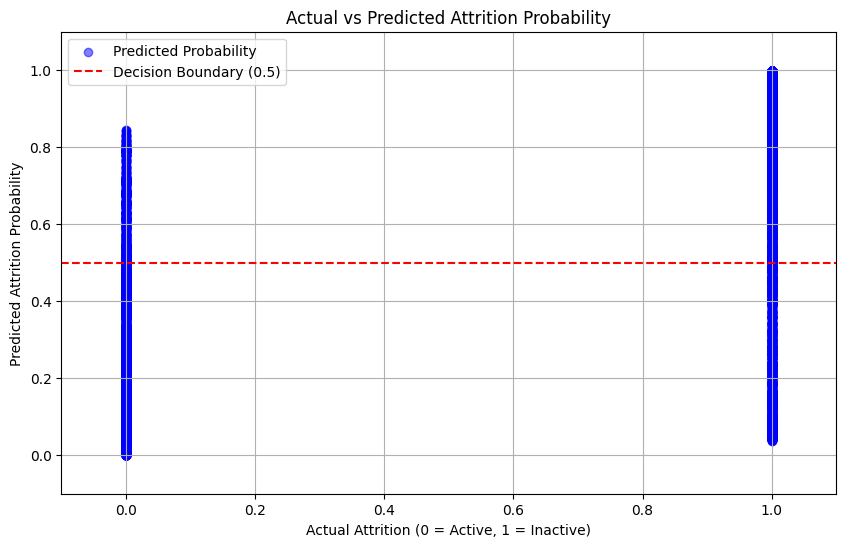

In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the threshold values for attrition based on tenure and average monthly spend
#threshold_years = df2['Tenure (Years)'].mean()  # or median as an alternative threshold
#yearly_spend_threshold = df2['Average Yearly Spend in USD'].mean()

# Example: using quantiles
threshold_years = merged_df['Tenure (Years)'].quantile(0.75)  # Using 75th percentile
yearly_spend_threshold = merged_df['Average Yearly Spend in USD'].quantile(0.25) # Using 25th percentile

# Define the 'Attrition' target column (1 for inactive, 0 for active)
df2['Attrition'] = ((merged_df['Tenure (Years)'] > threshold_years) |
                    (merged_df['Average Yearly Spend in USD'] < yearly_spend_threshold)
#                    | (merged_df['Number of Flights'] > flight_threshold)
                    ).astype(int)

# Check for class imbalance in the target variable
print(merged_df['Attrition'].value_counts())


# Define features (X) and target (y)
X = merged_df[['Lounge Used?', 'Planned Snack?', 'Additional Snack?', 'Flight Delayed?','Tenure (Years)', 'Average Yearly Spend in USD'
                  ,'Inquiry_Cancel Flight',
                  'Inquiry_Flight Deal',
                  'Inquiry_Flight Status',
                  'Inquiry_New Flight',#,'Number of Flights'
         ]]
y = merged_df['Attrition']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
logistic_model = LogisticRegression(max_iter=200, class_weight='balanced')
logistic_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = logistic_model.predict(X_test)
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (inactive)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting Actual vs Predicted Attrition
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_prob, alpha=0.5, color='blue', label='Predicted Probability')
plt.ylim(-0.1, 1.1)  # Predicted values between 0 and 1
plt.xlim(-0.1, 1.1)  # Actual values are 0 or 1
plt.xlabel("Actual Attrition (0 = Active, 1 = Inactive)")
plt.ylabel("Predicted Attrition Probability")
plt.title("Actual vs Predicted Attrition Probability")
plt.axhline(0.5, color='red', linestyle='--', label='Decision Boundary (0.5)')
plt.legend()
plt.grid(True)
plt.show()

## Test case prediction

In [104]:


# Initialize first_name and last_name to None in case they are not found
first_name = None
last_name = None

# Step 1: Locate data
test_case = merged_df[(merged_df['Frequent Flier Number'] == 7234617746)]

# Ensure we have data for the specified frequent flyer number
if test_case.empty:
    print("Test case data not found.")
else:
    first_name = test_case['First Name'].values[0]
    last_name = test_case['Last Name'].values[0]

    # Display thresholds for clarity
    print("Thresholds Used - Tenure:", tenure_threshold, " | Yearly Spend:", yearly_spend_threshold,"\n")

    # Step 2: Ensure required columns are present
    X_test_case = test_case[['Lounge Used?', 'Planned Snack?', 'Additional Snack?', 'Flight Delayed?', 'Tenure (Years)', 'Average Yearly Spend in USD'
                  ,'Inquiry_Cancel Flight',
                  'Inquiry_Flight Deal',
                  'Inquiry_Flight Status',
                  'Inquiry_New Flight',
                  ]]

    ## ---- Linear Regression Test Prediction ---- ##
    # Predict attrition likelihood with linear regression
    linear_pred = linear_model.predict(X_test_case)
    predicted_score = linear_pred[0]  # Get the first (and only) prediction
    print(f"Linear Regression Prediction for {first_name} {last_name} (Attrition Score):", predicted_score)
    print("R-squared:", r2)#,"\n"==)

    # Define threshold for interpretation
    threshold = 0.5

    # Interpret the result based on the threshold
    if predicted_score >= threshold:
        status = "likely not to remain a frequent flyer."
    else:
        status = "likely to remain a frequent flyer."

    print(f"Based on the linear prediction, {first_name} {last_name} is {status}\n")

    ## ---- Logistic Regression Test Prediction ---- ##
    # Predict attrition class (0 or 1) and probability with logistic regression
    logistic_pred_class = logistic_model.predict(X_test_case)
    logistic_pred_prob = logistic_model.predict_proba(X_test_case)[:, 1]  # Probability for class 1 (inactive)

    # Print the logistic regression predictions
    print(f"Logistic Regression Class Prediction for {first_name} {last_name} (Attrition):", logistic_pred_class[0])
    print(f"Logistic Regression Probability Prediction for {first_name} {last_name} (Inactive):", logistic_pred_prob[0])
    print("Accuracy:", accuracy_score(y_test, y_pred))#,'\n')

    # Step 3: Interpret the results
    # Interpret logistic prediction class
    if logistic_pred_class[0] == 1:
        # 1 means likely inactive
        status = "likely to not remain a frequent flyer."
    else:
        # 0 means likely active
        status = "likely to remain a frequent flyer."

    print(f"Based on the predictions, {first_name} {last_name} is {status}\n")

Thresholds Used - Tenure: 18.660344836984667  | Yearly Spend: 12781.71105 

Linear Regression Prediction for Debbie Spears (Attrition Score): 0.10517235352363663
R-squared: 0.4867306037644137
Based on the linear prediction, Debbie Spears is likely to remain a frequent flyer.

Logistic Regression Class Prediction for Debbie Spears (Attrition): False
Logistic Regression Probability Prediction for Debbie Spears (Inactive): 0.020566894506464917
Accuracy: 0.8480820631366034
Based on the predictions, Debbie Spears is likely to remain a frequent flyer.



Here’s the modified code that removes duplicates, adds the counts for both “not likely to remain a frequent flyer” and “likely to remain a frequent flyer,” and provides a comprehensive summary of the results:

In [107]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression

# Assuming linear_model and logistic_model are already trained

# Step 1: Prepare the feature set for all frequent flyers
feature_columns = [
    'Lounge Used?', 'Planned Snack?', 'Additional Snack?',
    'Flight Delayed?', 'Tenure (Years)', 'Average Yearly Spend in USD',
    'Inquiry_Cancel Flight', 'Inquiry_Flight Deal',
    'Inquiry_Flight Status', 'Inquiry_New Flight'
]

# Ensure the necessary columns are in the merged_df
X_all = merged_df[feature_columns]

# Step 2: Make predictions for all frequent flyers
# Linear regression prediction
linear_preds = linear_model.predict(X_all)

# Logistic regression predictions
logistic_preds_class = logistic_model.predict(X_all)
logistic_preds_prob = logistic_model.predict_proba(X_all)[:, 1]  # Probability for class 1 (inactive)

# Step 3: Add predictions to the dataframe
merged_df['Linear_Pred_Score'] = linear_preds
merged_df['Logistic_Pred_Class'] = logistic_preds_class
merged_df['Logistic_Pred_Prob'] = logistic_preds_prob

# Define a threshold for attrition (0.5)
threshold = 0.5

# Step 4: Determine likelihood of remaining a frequent flyer
merged_df['Linear_Status'] = merged_df['Linear_Pred_Score'].apply(lambda x: 'not likely to remain a frequent flyer' if x >= threshold else 'likely to remain a frequent flyer')
merged_df['Logistic_Status'] = merged_df['Logistic_Pred_Class'].apply(lambda x: 'not likely to remain a frequent flyer' if x == 1 else 'likely to remain a frequent flyer')

# Step 5: Remove duplicates
merged_df = merged_df.drop_duplicates(subset=['Frequent Flier Number'])

# Step 6: Count the number of flyers in each status category
status_counts = merged_df['Linear_Status'].value_counts().rename_axis('Status').reset_index(name='Count')

# Step 7: Filter for those who are likely not to remain
not_likely_to_remain_linear = merged_df[merged_df['Linear_Status'] == 'not likely to remain a frequent flyer']
likely_to_remain_linear = merged_df[merged_df['Linear_Status'] == 'likely to remain a frequent flyer']

# Step 8: Display results
#print("Frequent Flyers Not Likely to Remain (Linear Regression):")
#print(not_likely_to_remain_linear[['Frequent Flier Number', 'First Name', 'Last Name', 'Linear_Pred_Score', 'Linear_Status']])

#print("\nFrequent Flyers Likely to Remain (Linear Regression):")
#print(likely_to_remain_linear[['Frequent Flier Number', 'First Name', 'Last Name', 'Linear_Pred_Score', 'Linear_Status']])

print("\nCount of Frequent Flyers by Status (Linear Regression):")
print(status_counts)


Count of Frequent Flyers by Status (Linear Regression):
                                  Status  Count
0  not likely to remain a frequent flyer   1230
1      likely to remain a frequent flyer    770
